# Resultados Abalone

## Importación de recursos

In [1]:
import matplotlib
%matplotlib inline
%load_ext autoreload
%autoreload 2

import random as python_random
from numpy.random import seed
from tensorflow.random import set_seed

import os
import sys
import time
import pickle
import gzip

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pandas

import tensorflow 
from tensorflow import keras

import keras.losses
from keras.models import Model
from keras.layers import Input,Dense
from keras import regularizers
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.initializers import glorot_uniform
from keras.regularizers import L2

from sklearn.datasets import load_boston
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, make_scorer, mean_absolute_error

import scikeras
from scikeras.wrappers import KerasClassifier, BaseWrapper
from joblib import dump, load
from basewrapper import BaseWrapper

import matplotlib.pyplot as plt
import seaborn as sns

from joblib import load


C:\Users\aitor\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Definición de métodos para análisis de Abalone

In [2]:
def abalone_data():
    data = pd.read_csv("datos.csv", sep = ' ',  header=None, encoding = "ISO-8859-1").dropna()
    data[1] = data[1].replace({'1:':''}, regex=True).astype(float)
    data[2] = data[2].replace({'2:':''}, regex=True).astype(float)
    data[3] = data[3].replace({'3:':''}, regex=True).astype(float)
    data[4] = data[4].replace({'4:':''}, regex=True).astype(float)
    data[5] = data[5].replace({'5:':''}, regex=True).astype(float)
    data[6] = data[6].replace({'6:':''}, regex=True).astype(float)
    data[7] = data[7].replace({'7:':''}, regex=True).astype(float)
    data[8] = data[8].replace({'8:':''}, regex=True).astype(float)
    x = data[[1,2,3,4,5,6,7,8]].values
    y = data[0].values
    return x,y


    
# Crear las capas
def network(l2):
    """
    Builds functional MLP Keras model for companion categorical_crossentropy and mse losses,
    softmax and linear outputs respectively, relu activations, adam solver.
    
    ### Arguments:
        input_shape: feature dimension
        output_shape: target dimension
        hidden_layer_sizes: list with number of units on hidden layers
        regr_loss: regression loss; mse or mean_absolute_error
        alpha: parameter for l2 kernel regularizers for all layers
        
    ### Returns:
        model: Model
    """
    set_seed(123)
    input_layer = Input(shape=(8,), name = 'input_layer')
    layer_1 = Dense(50, activation="relu", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'layer_1')(input_layer)
    layer_2 = Dense(50, activation="relu", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'layer_2')(layer_1)
    output_layer= Dense(1, activation="linear", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'output_layer')(layer_2)
    ##Defining the model by specifying the input and output layers
    model = Model(inputs=input_layer, outputs=output_layer)
    ## defining the optimiser and loss function
    model.compile(optimizer='adam', loss='mse', metrics = 'mae')
    return model

class CompanionWrapper(BaseWrapper):
    """
    Predictions made on the RR outputs.
    """
        
    def __init__(self, model = network, **sk_params):
        BaseWrapper.__init__(self, model=model, **sk_params)
    

    def fit(self, x, y, **kwargs):
    	  
        
        """
        Assumes class codings as consecutive labels 0, 1, ...
        """    
        es = keras.callbacks.EarlyStopping(monitor="loss",
                                        min_delta=1.e-8,
                                        patience=50,
                                        verbose=0,
                                        mode="auto",
                                        baseline=None,
                                        restore_best_weights=True,
    
        )
	  
        y_regr = y
        
        self.X_dtype_ = type(x)
        self.X_shape_ = x.shape


        self.history_ = BaseWrapper.fit(self, x, {'output_layer':y_regr},
                                        epochs = self.epochs, initial_epoch = 0, callbacks = [es])

        return self.history_

    # Convertir la salida a rango [5,50] respetando el contexto.
    def predict(self, x, **kwargs):
        """
        We just drop the mse predictions of the model and keep the CE ones
        in the first returned list.
        """
        pred = BaseWrapper.predict(self, x)
        return np.clip(pred, a_min = 0, a_max = 1)
    
    def score(self, x, y):
        y_pred = BaseWrapper.predict(self, x)
        y_pred = np.clip(y_pred, a_min = 0, a_max = 1)
        return mean_absolute_error(y, y_pred)

def fc_mae(y, y_pred, **kwargs):
    return -mean_absolute_error(y[ : , 0], y_pred) 

mi_scoring = make_scorer(fc_mae) 
x,y=abalone_data()

# Modelo mse

## Ajuste de hiperparámetros

best_alpha = 0.00010
best_cv_mae = 1.468


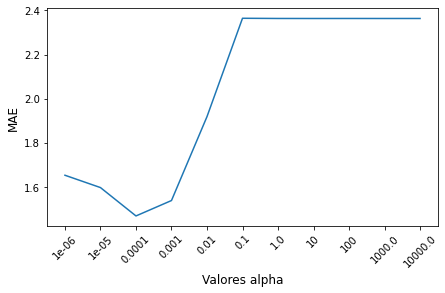

In [3]:
python_random.seed(123) 
set_seed(123)
seed(123) 

regr = load('regr_wrap.joblib')
plt.figure(figsize=(7, 4))
l_alpha = [1e-6, 1e-5, 1e-4, 0.001, 0.01, 0.1, 1.0, 10, 100, 1e+3, 1e+4, 1e+5]
print('best_alpha = %.5f' % regr.best_params_['regressor__mlp__l2'])
print('best_cv_mae = %.3f' % (-regr.best_score_))
plt.xticks(range(len(l_alpha)), l_alpha, rotation=45)
plt.xlabel('Valores alpha', fontsize=12)
plt.ylabel("MAE", fontsize=12)
plt.plot(-regr.cv_results_['mean_test_score'])
plt.savefig('regr_param.png', bbox_inches = 'tight')
plt.show()


## Evaluación del modelo

In [4]:
set_seed(1)
kf = KFold(5, shuffle=True, random_state=1)
res = cross_val_predict(regr.best_estimator_, x, y, cv=kf)
for i in range(2,4):
    kf = KFold(5, shuffle=True, random_state=i)
    set_seed(1)
    pred = cross_val_predict(regr.best_estimator_, x, y, cv=kf)
    res = np.dstack((res,pred))
    
res = np.mean(res[0],axis=1)
print(mean_absolute_error(res, y))

1.462093931937406


# Modelo mse + ec

## Escenario K=2

In [5]:

def network(l2, lw):
    """
    Builds functional MLP Keras model for companion categorical_crossentropy and mse losses,
    softmax and linear outputs respectively, relu activations, adam solver.
    
    ### Arguments:
        input_shape: feature dimension
        output_shape: target dimension
        hidden_layer_sizes: list with number of units on hidden layers
        regr_loss: regression loss; mse or mean_absolute_error
        alpha: parameter for l2 kernel regularizers for all layers
        
    ### Returns:
        model: Model
    """
    set_seed(123)
    input_layer = Input(shape=(8,),name = "input_layer")
    layer_1 = Dense(50, activation="relu", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'layer_1')(input_layer)
    layer_2 = Dense(50, activation="relu", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'layer_2')(layer_1)
    regr_layer = Dense(1, activation="linear", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'regr_layer')(layer_2)
    clas_layer = Dense(2, activation="softmax", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'clas_layer')(layer_2)
    ##Defining the model by specifying the input and output layers
    network_ = Model(inputs=[input_layer], outputs=[regr_layer, clas_layer])
    ## defining the optimiser and loss function
    network_.compile(optimizer='adam',
                   loss={'regr_layer':'mse','clas_layer': 'categorical_crossentropy'},
                   loss_weights= {"regr_layer":1.0, "clas_layer": lw},
                   metrics = {'regr_layer':'mae', "clas_layer": 'accuracy'})
    return(network_)

def set_seed(seed):

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

    os.environ['PYTHONHASHSEED'] = str(seed)
    python_random.seed(seed)
    tensorflow.random.set_seed(seed)
    np.random.seed(seed)

class PartialMinMaxScaler(MinMaxScaler):
    """Applies the scaler in super() to the first column of the 
    numpy array to be scaled,
    """
    def fit(self, x):
        super().fit(x[ : , 0].reshape(-1, 1))
        
    def transform(self, x):
        xx = x.copy()
        xx_0 = super().transform(x[ : , 0].reshape(-1, 1))
        xx = np.concatenate([xx_0.reshape(-1,1),xx[:,1].reshape(-1,1)], axis = 1)
        return xx
        
    def fit_transform(self, x):
        self.fit(x)
        return self.transform(x)

    def inverse_transform(self, x):
        xx = x.copy()
        x_0 = super().inverse_transform(x[ : , 0].reshape(-1, 1))
        xx[ : , 0] = x_0.reshape(-1, )
        return xx


def fc_mae(y, y_pred, **kwargs):
    return -mean_absolute_error(y[ : , 0], y_pred) 

def abalone_data():
    data = pd.read_csv("datos.csv", sep = ' ',  header=None, encoding = "ISO-8859-1").dropna()
    data[1] = data[1].replace({'1:':''}, regex=True).astype(int)
    data[2] = data[2].replace({'2:':''}, regex=True).astype(float)
    data[3] = data[3].replace({'3:':''}, regex=True).astype(float)
    data[4] = data[4].replace({'4:':''}, regex=True).astype(float)
    data[5] = data[5].replace({'5:':''}, regex=True).astype(float)
    data[6] = data[6].replace({'6:':''}, regex=True).astype(float)
    data[7] = data[7].replace({'7:':''}, regex=True).astype(float)
    data[8] = data[8].replace({'8:':''}, regex=True).astype(float)
    x = data[[1,2,3,4,5,6,7,8]].values
    y = data[0].values
    return x,y


class CompanionWrapper(BaseWrapper):
    """
    Predictions made on the RR outputs.
    """
    def __init__(self, model = network, **sk_params):
        BaseWrapper.__init__(self, model=model, **sk_params)
    def fit(self, x, y, **kwargs):
        """
        Assumes class codings as consecutive labels 0, 1, ...
        """        
        es = keras.callbacks.EarlyStopping(monitor="loss",
                                            min_delta=1.e-8,
                                            patience=50,
                                            verbose=0,
                                            mode="auto",
                                            baseline=None,
                                            restore_best_weights=True,
                                            )
        
        y_regr = y[:,0]
        y_clas = y[:,1]
        onehot = to_categorical(y_clas)
        
        self.X_dtype_ = type(x)
        self.X_shape_ = x.shape
        
        self.history_ = BaseWrapper.fit(self, x,
                                        {'regr_layer':y_regr,'clas_layer':onehot},
                                        epochs = self.epochs, initial_epoch = 0,
                                       callbacks = [es])

        return self.history_

    # Convertir la salida a rango [5,50.000] respetando el contexto.
    def predict(self, x, **kwargs):
        """
        We just drop the mse predictions of the model and keep the CE ones
        in the first returned list.
        """
        pred = BaseWrapper.predict(self, x)[0]
        return np.clip(pred, a_min = 0, a_max = 1)
    
    def score(self, x, y):
        y_pred = BaseWrapper.predict(self, x)[0]
        y_pred = np.clip(y_pred, a_min = 0, a_max = 1)
        return mean_absolute_error(y[:,0], y_pred)



## Ajuste de hiperparámetros

In [6]:
python_random.seed(123) 
set_seed(123)
seed(123) 

comp1_K2 = load('comp_wrap_K2.joblib')

In [7]:
lw0 = []
lw1 = []
lw2 = []
lw3 = []
lw4 = []
lw5 = []
lw6 = []
lw7 = []
lw8 = []
lw9 = []
lw10 = []
lw11 = []
lw12 = []
lw13 = []
lw14 = []
lw15 = []
lw16 = []
lw17 = []
lw18 = []
lw19 = []
for i in range(0,220):
    if i % 20==0:
        lw0.append(i)
    elif i % 20==1:
        lw1.append(i)
    elif i % 20==2:
        lw2.append(i)
    elif i % 20==3:
        lw3.append(i)
    elif i % 20==4:
        lw4.append(i)
    elif i % 20==5:
        lw5.append(i)
    elif i % 20==6:
        lw6.append(i)
    elif i % 20==7:
        lw7.append(i)
    elif i % 20==8:
        lw8.append(i)
    elif i % 20==9:
        lw9.append(i)
    if i % 20==10:
        lw10.append(i)
    elif i % 20==11:
        lw11.append(i)
    elif i % 20==12:
        lw12.append(i)
    elif i % 20==13:
        lw13.append(i)
    elif i % 20==14:
        lw14.append(i)
    elif i % 20==15:
        lw15.append(i)
    elif i % 20==16:
        lw16.append(i)
    elif i % 20==17:
        lw17.append(i)
    elif i % 20==18:
        lw18.append(i)
    elif i % 20==19:
        lw19.append(i)
        
res0 = comp1_K2.cv_results_['mean_test_score'][lw0]
res1 = comp1_K2.cv_results_['mean_test_score'][lw1]
res2 = comp1_K2.cv_results_['mean_test_score'][lw2]
res3 = comp1_K2.cv_results_['mean_test_score'][lw3]
res4 = comp1_K2.cv_results_['mean_test_score'][lw4]
res5 = comp1_K2.cv_results_['mean_test_score'][lw5]
res6 = comp1_K2.cv_results_['mean_test_score'][lw6]
res7 = comp1_K2.cv_results_['mean_test_score'][lw7]
res8 = comp1_K2.cv_results_['mean_test_score'][lw8]
res9 = comp1_K2.cv_results_['mean_test_score'][lw9]
res10 = comp1_K2.cv_results_['mean_test_score'][lw10]
res11 = comp1_K2.cv_results_['mean_test_score'][lw11]
res12 = comp1_K2.cv_results_['mean_test_score'][lw12]
res13 = comp1_K2.cv_results_['mean_test_score'][lw13]
res14 = comp1_K2.cv_results_['mean_test_score'][lw14]
res15 = comp1_K2.cv_results_['mean_test_score'][lw15]
res16 = comp1_K2.cv_results_['mean_test_score'][lw16]
res17 = comp1_K2.cv_results_['mean_test_score'][lw17]
res18 = comp1_K2.cv_results_['mean_test_score'][lw18]
res19 = comp1_K2.cv_results_['mean_test_score'][lw19]


best_alpha = 0.0001
best_lw = 0.0000
best_cv_mae = -1.468


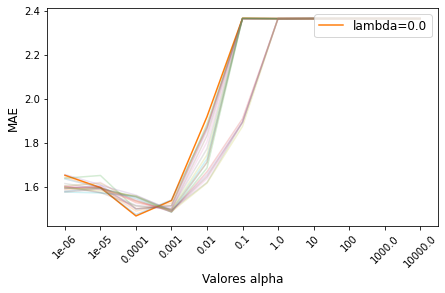

In [8]:
l_alpha = [1e-6, 1e-5, 1e-4, 0.001, 0.01, 0.1, 1.0, 10, 100, 1e+3, 1e+4, 1e+5]
res0 = comp1_K2.cv_results_['mean_test_score'][lw0]
plt.figure( figsize=(7,4))
print('best_alpha = %.4f' % comp1_K2.best_params_['regressor__mlp__l2'])
print('best_lw = %.4f' % comp1_K2.best_params_['regressor__mlp__lw'])
print('best_cv_mae = %.3f' % (comp1_K2.best_score_))
plt.xticks(range(len(l_alpha)), l_alpha, rotation=45)
plt.xlabel('Valores alpha', fontsize=12)
plt.ylabel("MAE", fontsize=12)
plt.plot(-res0, label = "lambda=0.0", color='C1')
plt.plot(-res1, alpha=0.2)
plt.plot(-res2, alpha=0.2)
plt.plot(-res3, alpha=0.2)
plt.plot(-res4, alpha=0.2)
plt.plot(-res5, alpha=0.2)
plt.plot(-res6, alpha=0.2)
plt.plot(-res7, alpha=0.2)
plt.plot(-res8, alpha=0.2)
plt.plot(-res9, alpha=0.2)
plt.plot(-res10, alpha=0.2)
plt.plot(-res11, alpha=0.2)
plt.plot(-res12, alpha=0.2)
plt.plot(-res13, alpha=0.2)
plt.plot(-res14, alpha=0.2)
plt.plot(-res15, alpha=0.2)
plt.plot(-res16, alpha=0.2)
plt.plot(-res17, alpha=0.2)
plt.plot(-res18, alpha=0.2)
plt.plot(-res19, alpha=0.2)
plt.legend(loc=1, prop={'size': 12})
plt.savefig('comp1_wrap_K2_param.png', bbox_inches = 'tight')
plt.show()


## Evaluación del modelo

In [9]:
set_seed(1)
kf = KFold(5, shuffle=True, random_state=1)
q = np.quantile(y, [0,.5,1])
y_clas = np.array(pd.cut(x=y.reshape(-1,), bins=q, labels=[0, 1], include_lowest=True, right=True))
target = np.concatenate([y.reshape(-1,1),y_clas.reshape(-1,1)], axis = 1)
kf = KFold(5, shuffle=True, random_state=1)
res = cross_val_predict(comp1_K2.best_estimator_, x, target, cv=kf)
for i in range(2,4):
    kf = KFold(5, shuffle=True, random_state=i)
    set_seed(1)
    pred = cross_val_predict(comp1_K2.best_estimator_, x, target, cv=kf)
    res = np.dstack((res,pred))
    
result = np.mean(res[:,0,:], axis=1)
print(mean_absolute_error(result, y))

1.462093931937406


## Escenario K=5

In [15]:

def network(l2, lw):
    """
    Builds functional MLP Keras model for companion categorical_crossentropy and mse losses,
    softmax and linear outputs respectively, relu activations, adam solver.
    
    ### Arguments:
        input_shape: feature dimension
        output_shape: target dimension
        hidden_layer_sizes: list with number of units on hidden layers
        regr_loss: regression loss; mse or mean_absolute_error
        alpha: parameter for l2 kernel regularizers for all layers
        
    ### Returns:
        model: Model
    """
    set_seed(123)
    input_layer = Input(shape=(8,),name = "input_layer")
    layer_1 = Dense(50, activation="relu", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'layer_1')(input_layer)
    layer_2 = Dense(50, activation="relu", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'layer_2')(layer_1)
    regr_layer = Dense(1, activation="linear", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'regr_layer')(layer_2)
    clas_layer = Dense(5, activation="softmax", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'clas_layer')(layer_2)
    ##Defining the model by specifying the input and output layers
    network_ = Model(inputs=[input_layer], outputs=[regr_layer, clas_layer])
    ## defining the optimiser and loss function
    network_.compile(optimizer='adam',
                   loss={'regr_layer':'mse','clas_layer': 'categorical_crossentropy'},
                   loss_weights= {"regr_layer":1.0, "clas_layer": lw},
                   metrics = {'regr_layer':'mae', "clas_layer": 'accuracy'})
    return(network_)

def set_seed(seed):

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

    os.environ['PYTHONHASHSEED'] = str(seed)
    python_random.seed(seed)
    tensorflow.random.set_seed(seed)
    np.random.seed(seed)

class PartialMinMaxScaler(MinMaxScaler):
    """Applies the scaler in super() to the first column of the 
    numpy array to be scaled,
    """
    def fit(self, x):
        super().fit(x[ : , 0].reshape(-1, 1))
        
    def transform(self, x):
        xx = x.copy()
        xx_0 = super().transform(x[ : , 0].reshape(-1, 1))
        xx = np.concatenate([xx_0.reshape(-1,1),xx[:,1].reshape(-1,1)], axis = 1)
        return xx
        
    def fit_transform(self, x):
        self.fit(x)
        return self.transform(x)

    def inverse_transform(self, x):
        xx = x.copy()
        x_0 = super().inverse_transform(x[ : , 0].reshape(-1, 1))
        xx[ : , 0] = x_0.reshape(-1, )
        return xx


def fc_mae(y, y_pred, **kwargs):
    return -mean_absolute_error(y[ : , 0], y_pred) 

def abalone_data():
    data = pd.read_csv("datos.csv", sep = ' ',  header=None, encoding = "ISO-8859-1").dropna()
    data[1] = data[1].replace({'1:':''}, regex=True).astype(int)
    data[2] = data[2].replace({'2:':''}, regex=True).astype(float)
    data[3] = data[3].replace({'3:':''}, regex=True).astype(float)
    data[4] = data[4].replace({'4:':''}, regex=True).astype(float)
    data[5] = data[5].replace({'5:':''}, regex=True).astype(float)
    data[6] = data[6].replace({'6:':''}, regex=True).astype(float)
    data[7] = data[7].replace({'7:':''}, regex=True).astype(float)
    data[8] = data[8].replace({'8:':''}, regex=True).astype(float)
    x = data[[1,2,3,4,5,6,7,8]].values
    y = data[0].values
    return x,y


class CompanionWrapper(BaseWrapper):
    """
    Predictions made on the RR outputs.
    """
    def __init__(self, model = network, **sk_params):
        BaseWrapper.__init__(self, model=model, **sk_params)
    def fit(self, x, y, **kwargs):
        """
        Assumes class codings as consecutive labels 0, 1, ...
        """        
        es = keras.callbacks.EarlyStopping(monitor="loss",
                                            min_delta=1.e-8,
                                            patience=50,
                                            verbose=0,
                                            mode="auto",
                                            baseline=None,
                                            restore_best_weights=True,
                                            )
        
        y_regr = y[:,0]
        y_clas = y[:,1]
        onehot = to_categorical(y_clas)
        
        self.X_dtype_ = type(x)
        self.X_shape_ = x.shape
        
        self.history_ = BaseWrapper.fit(self, x,
                                        {'regr_layer':y_regr,'clas_layer':onehot},
                                        epochs = self.epochs, initial_epoch = 0,
                                       callbacks = [es])

        return self.history_

    # Convertir la salida a rango [5,50.000] respetando el contexto.
    def predict(self, x, **kwargs):
        """
        We just drop the mse predictions of the model and keep the CE ones
        in the first returned list.
        """
        pred = BaseWrapper.predict(self, x)[0]
        return np.clip(pred, a_min = 0, a_max = 1)
    
    def score(self, x, y):
        y_pred = BaseWrapper.predict(self, x)[0]
        y_pred = np.clip(y_pred, a_min = 0, a_max = 1)
        return mean_absolute_error(y[:,0], y_pred)


## Ajuste de hiperparámetros

In [16]:
python_random.seed(123) 
set_seed(123)
seed(123) 

comp1_K3 = load('comp_wrap_K5.joblib')

In [17]:
lw0 = []
lw1 = []
lw2 = []
lw3 = []
lw4 = []
lw5 = []
lw6 = []
lw7 = []
lw8 = []
lw9 = []
lw10 = []
lw11 = []
lw12 = []
lw13 = []
lw14 = []
lw15 = []
lw16 = []
lw17 = []
lw18 = []
lw19 = []
for i in range(0,220):
    if i % 20==0:
        lw0.append(i)
    elif i % 20==1:
        lw1.append(i)
    elif i % 20==2:
        lw2.append(i)
    elif i % 20==3:
        lw3.append(i)
    elif i % 20==4:
        lw4.append(i)
    elif i % 20==5:
        lw5.append(i)
    elif i % 20==6:
        lw6.append(i)
    elif i % 20==7:
        lw7.append(i)
    elif i % 20==8:
        lw8.append(i)
    elif i % 20==9:
        lw9.append(i)
    if i % 20==10:
        lw10.append(i)
    elif i % 20==11:
        lw11.append(i)
    elif i % 20==12:
        lw12.append(i)
    elif i % 20==13:
        lw13.append(i)
    elif i % 20==14:
        lw14.append(i)
    elif i % 20==15:
        lw15.append(i)
    elif i % 20==16:
        lw16.append(i)
    elif i % 20==17:
        lw17.append(i)
    elif i % 20==18:
        lw18.append(i)
    elif i % 20==19:
        lw19.append(i)
        
res0 = comp1_K3.cv_results_['mean_test_score'][lw0]
res1 = comp1_K3.cv_results_['mean_test_score'][lw1]
res2 = comp1_K3.cv_results_['mean_test_score'][lw2]
res3 = comp1_K3.cv_results_['mean_test_score'][lw3]
res4 = comp1_K3.cv_results_['mean_test_score'][lw4]
res5 = comp1_K3.cv_results_['mean_test_score'][lw5]
res6 = comp1_K3.cv_results_['mean_test_score'][lw6]
res7 = comp1_K3.cv_results_['mean_test_score'][lw7]
res8 = comp1_K3.cv_results_['mean_test_score'][lw8]
res9 = comp1_K3.cv_results_['mean_test_score'][lw9]
res10 = comp1_K3.cv_results_['mean_test_score'][lw10]
res11 = comp1_K3.cv_results_['mean_test_score'][lw11]
res12 = comp1_K3.cv_results_['mean_test_score'][lw12]
res13 = comp1_K3.cv_results_['mean_test_score'][lw13]
res14 = comp1_K3.cv_results_['mean_test_score'][lw14]
res15 = comp1_K3.cv_results_['mean_test_score'][lw15]
res16 = comp1_K3.cv_results_['mean_test_score'][lw16]
res17 = comp1_K3.cv_results_['mean_test_score'][lw17]
res18 = comp1_K3.cv_results_['mean_test_score'][lw18]
res19 = comp1_K3.cv_results_['mean_test_score'][lw19]


best_alpha = 0.0001
best_lw = 0.0000
best_cv_mae = -1.468


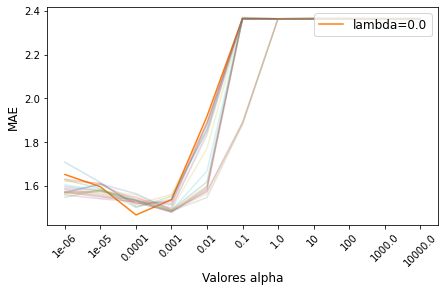

In [18]:
l_alpha = [1e-6, 1e-5, 1e-4, 0.001, 0.01, 0.1, 1.0, 10, 100, 1e+3, 1e+4, 1e+5]
res0 = comp1_K3.cv_results_['mean_test_score'][lw0]
plt.figure( figsize=(7,4))
print('best_alpha = %.4f' % comp1_K3.best_params_['regressor__mlp__l2'])
print('best_lw = %.4f' % comp1_K3.best_params_['regressor__mlp__lw'])
print('best_cv_mae = %.3f' % (comp1_K3.best_score_))
plt.xticks(range(len(l_alpha)), l_alpha, rotation=45)
plt.xlabel('Valores alpha', fontsize=12)
plt.ylabel("MAE", fontsize=12)
plt.plot(-res0, label = "lambda=0.0", color='C1')
plt.plot(-res1, alpha=0.2)
plt.plot(-res2, alpha=0.2)
plt.plot(-res3, alpha=0.2)
plt.plot(-res4, alpha=0.2)
plt.plot(-res5, alpha=0.2)
plt.plot(-res6, alpha=0.2)
plt.plot(-res7, alpha=0.2)
plt.plot(-res8, alpha=0.2)
plt.plot(-res9, alpha=0.2)
plt.plot(-res10, alpha=0.2)
plt.plot(-res11, alpha=0.2)
plt.plot(-res12, alpha=0.2)
plt.plot(-res13, alpha=0.2)
plt.plot(-res14, alpha=0.2)
plt.plot(-res15, alpha=0.2)
plt.plot(-res16, alpha=0.2)
plt.plot(-res17, alpha=0.2)
plt.plot(-res18, alpha=0.2)
plt.plot(-res19, alpha=0.2)
plt.legend(loc=1, prop={'size': 12})
plt.savefig('comp1_wrap_K5_param.png', bbox_inches = 'tight')
plt.show()


## Evaluación del modelo

In [9]:
set_seed(1)
kf = KFold(5, shuffle=True, random_state=1)
q = np.quantile(y, [0,.2,.4,.6,.8,1])
y_clas = np.array(pd.cut(x=y.reshape(-1,), bins=q, labels=[0, 1,2,3,4], include_lowest=True, right=True))
target = np.concatenate([y.reshape(-1,1),y_clas.reshape(-1,1)], axis = 1)
res = cross_val_score(comp1_K3.best_estimator_, x, target, cv=kf, scoring=mi_scoring)
for i in range(2,4):
    kf = KFold(5, shuffle=True, random_state=i)
    set_seed(1)
    pred = cross_val_predict(comp1_K3.best_estimator_, x, target, cv=kf)
    res = np.dstack((res,pred))
    
result = np.mean(res[:,0,:], axis=1)
print(mean_absolute_error(result, y))

1.462093931937406


## Escenario K=4

In [20]:
def network(l2, lw):
    """
    Builds functional MLP Keras model for companion categorical_crossentropy and mse losses,
    softmax and linear outputs respectively, relu activations, adam solver.
    
    ### Arguments:
        input_shape: feature dimension
        output_shape: target dimension
        hidden_layer_sizes: list with number of units on hidden layers
        regr_loss: regression loss; mse or mean_absolute_error
        alpha: parameter for l2 kernel regularizers for all layers
        
    ### Returns:
        model: Model
    """
    set_seed(123)
    input_layer = Input(shape=(8,),name = "input_layer")
    layer_1 = Dense(50, activation="relu", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'layer_1')(input_layer)
    layer_2 = Dense(50, activation="relu", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'layer_2')(layer_1)
    regr_layer = Dense(1, activation="linear", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'regr_layer')(layer_2)
    clas_layer = Dense(4, activation="softmax", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'clas_layer')(layer_2)
    ##Defining the model by specifying the input and output layers
    network_ = Model(inputs=[input_layer], outputs=[regr_layer, clas_layer])
    ## defining the optimiser and loss function
    network_.compile(optimizer='adam',
                   loss={'regr_layer':'mse','clas_layer': 'categorical_crossentropy'},
                   loss_weights= {"regr_layer":1.0, "clas_layer": lw},
                   metrics = {'regr_layer':'mae', "clas_layer": 'accuracy'})
    return(network_)

def set_seed(seed):

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

    os.environ['PYTHONHASHSEED'] = str(seed)
    python_random.seed(seed)
    tensorflow.random.set_seed(seed)
    np.random.seed(seed)

class PartialMinMaxScaler(MinMaxScaler):
    """Applies the scaler in super() to the first column of the 
    numpy array to be scaled,
    """
    def fit(self, x):
        super().fit(x[ : , 0].reshape(-1, 1))
        
    def transform(self, x):
        xx = x.copy()
        xx_0 = super().transform(x[ : , 0].reshape(-1, 1))
        xx = np.concatenate([xx_0.reshape(-1,1),xx[:,1].reshape(-1,1)], axis = 1)
        return xx
        
    def fit_transform(self, x):
        self.fit(x)
        return self.transform(x)

    def inverse_transform(self, x):
        xx = x.copy()
        x_0 = super().inverse_transform(x[ : , 0].reshape(-1, 1))
        xx[ : , 0] = x_0.reshape(-1, )
        return xx


def fc_mae(y, y_pred, **kwargs):
    return -mean_absolute_error(y[ : , 0], y_pred) 

def abalone_data():
    data = pd.read_csv("datos.csv", sep = ' ',  header=None, encoding = "ISO-8859-1").dropna()
    data[1] = data[1].replace({'1:':''}, regex=True).astype(int)
    data[2] = data[2].replace({'2:':''}, regex=True).astype(float)
    data[3] = data[3].replace({'3:':''}, regex=True).astype(float)
    data[4] = data[4].replace({'4:':''}, regex=True).astype(float)
    data[5] = data[5].replace({'5:':''}, regex=True).astype(float)
    data[6] = data[6].replace({'6:':''}, regex=True).astype(float)
    data[7] = data[7].replace({'7:':''}, regex=True).astype(float)
    data[8] = data[8].replace({'8:':''}, regex=True).astype(float)
    x = data[[1,2,3,4,5,6,7,8]].values
    y = data[0].values
    return x,y


class CompanionWrapper(BaseWrapper):
    """
    Predictions made on the RR outputs.
    """
    def __init__(self, model = network, **sk_params):
        BaseWrapper.__init__(self, model=model, **sk_params)
    def fit(self, x, y, **kwargs):
        """
        Assumes class codings as consecutive labels 0, 1, ...
        """        
        es = keras.callbacks.EarlyStopping(monitor="loss",
                                            min_delta=1.e-8,
                                            patience=50,
                                            verbose=0,
                                            mode="auto",
                                            baseline=None,
                                            restore_best_weights=True,
                                            )
        
        y_regr = y[:,0]
        y_clas = y[:,1]
        onehot = to_categorical(y_clas)
        
        self.X_dtype_ = type(x)
        self.X_shape_ = x.shape
        
        self.history_ = BaseWrapper.fit(self, x,
                                        {'regr_layer':y_regr,'clas_layer':onehot},
                                        epochs = self.epochs, initial_epoch = 0,
                                       callbacks = [es])

        return self.history_

    # Convertir la salida a rango [5,50.000] respetando el contexto.
    def predict(self, x, **kwargs):
        """
        We just drop the mse predictions of the model and keep the CE ones
        in the first returned list.
        """
        pred = BaseWrapper.predict(self, x)[0]
        return np.clip(pred, a_min = 0, a_max = 1)
    
    def score(self, x, y):
        y_pred = BaseWrapper.predict(self, x)[0]
        y_pred = np.clip(y_pred, a_min = 0, a_max = 1)
        return mean_absolute_error(y[:,0], y_pred)



## Ajuste de hiperparámetros

In [21]:
python_random.seed(123) 
set_seed(123)
seed(123) 

comp1_K4 = load('comp_wrap_K4.joblib')

In [22]:
lw0 = []
lw1 = []
lw2 = []
lw3 = []
lw4 = []
lw5 = []
lw6 = []
lw7 = []
lw8 = []
lw9 = []
lw10 = []
lw11 = []
lw12 = []
lw13 = []
lw14 = []
lw15 = []
lw16 = []
lw17 = []
lw18 = []
lw19 = []
for i in range(0,220):
    if i % 20==0:
        lw0.append(i)
    elif i % 20==1:
        lw1.append(i)
    elif i % 20==2:
        lw2.append(i)
    elif i % 20==3:
        lw3.append(i)
    elif i % 20==4:
        lw4.append(i)
    elif i % 20==5:
        lw5.append(i)
    elif i % 20==6:
        lw6.append(i)
    elif i % 20==7:
        lw7.append(i)
    elif i % 20==8:
        lw8.append(i)
    elif i % 20==9:
        lw9.append(i)
    if i % 20==10:
        lw10.append(i)
    elif i % 20==11:
        lw11.append(i)
    elif i % 20==12:
        lw12.append(i)
    elif i % 20==13:
        lw13.append(i)
    elif i % 20==14:
        lw14.append(i)
    elif i % 20==15:
        lw15.append(i)
    elif i % 20==16:
        lw16.append(i)
    elif i % 20==17:
        lw17.append(i)
    elif i % 20==18:
        lw18.append(i)
    elif i % 20==19:
        lw19.append(i)
        
res0 = comp1_K4.cv_results_['mean_test_score'][lw0]
res1 = comp1_K4.cv_results_['mean_test_score'][lw1]
res2 = comp1_K4.cv_results_['mean_test_score'][lw2]
res3 = comp1_K4.cv_results_['mean_test_score'][lw3]
res4 = comp1_K4.cv_results_['mean_test_score'][lw4]
res5 = comp1_K4.cv_results_['mean_test_score'][lw5]
res6 = comp1_K4.cv_results_['mean_test_score'][lw6]
res7 = comp1_K4.cv_results_['mean_test_score'][lw7]
res8 = comp1_K4.cv_results_['mean_test_score'][lw8]
res9 = comp1_K4.cv_results_['mean_test_score'][lw9]
res10 = comp1_K4.cv_results_['mean_test_score'][lw10]
res11 = comp1_K4.cv_results_['mean_test_score'][lw11]
res12 = comp1_K4.cv_results_['mean_test_score'][lw12]
res13 = comp1_K4.cv_results_['mean_test_score'][lw13]
res14 = comp1_K4.cv_results_['mean_test_score'][lw14]
res15 = comp1_K4.cv_results_['mean_test_score'][lw15]
res16 = comp1_K4.cv_results_['mean_test_score'][lw16]
res17 = comp1_K4.cv_results_['mean_test_score'][lw17]
res18 = comp1_K4.cv_results_['mean_test_score'][lw18]
res19 = comp1_K4.cv_results_['mean_test_score'][lw19]


best_alpha = 0.0001
best_lw = 0.0000
best_cv_mae = -1.468


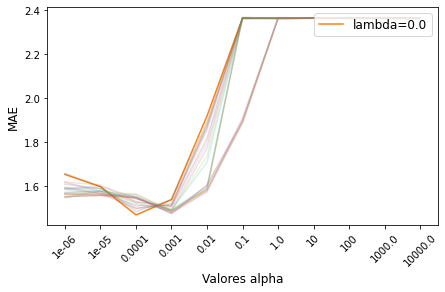

In [23]:
l_alpha = [1e-6, 1e-5, 1e-4, 0.001, 0.01, 0.1, 1.0, 10, 100, 1e+3, 1e+4, 1e+5]
res0 = comp1_K4.cv_results_['mean_test_score'][lw0]
plt.figure( figsize=(7,4))
print('best_alpha = %.4f' % comp1_K4.best_params_['regressor__mlp__l2'])
print('best_lw = %.4f' % comp1_K4.best_params_['regressor__mlp__lw'])
print('best_cv_mae = %.3f' % (comp1_K4.best_score_))
plt.xticks(range(len(l_alpha)), l_alpha, rotation=45)
plt.xlabel('Valores alpha', fontsize=12)
plt.ylabel("MAE", fontsize=12)
plt.plot(-res0, label = "lambda=0.0", color='C1')
plt.plot(-res1, alpha=0.2)
plt.plot(-res2, alpha=0.2)
plt.plot(-res3, alpha=0.2)
plt.plot(-res4, alpha=0.2)
plt.plot(-res5, alpha=0.2)
plt.plot(-res6, alpha=0.2)
plt.plot(-res7, alpha=0.2)
plt.plot(-res8, alpha=0.2)
plt.plot(-res9, alpha=0.2)
plt.plot(-res10, alpha=0.2)
plt.plot(-res11, alpha=0.2)
plt.plot(-res12, alpha=0.2)
plt.plot(-res13, alpha=0.2)
plt.plot(-res14, alpha=0.2)
plt.plot(-res15, alpha=0.2)
plt.plot(-res16, alpha=0.2)
plt.plot(-res17, alpha=0.2)
plt.plot(-res18, alpha=0.2)
plt.plot(-res19, alpha=0.2)
plt.legend(loc=1, prop={'size': 12})
plt.savefig('comp1_wrap_K4_param.png', bbox_inches = 'tight')
plt.show()


## Evaluación del modelo

In [9]:
set_seed(1)
kf = KFold(5, shuffle=True, random_state=1)
q = np.quantile(y, [0,.25,.5,.75,1])
y_clas = np.array(pd.cut(x=y.reshape(-1,), bins=q, labels=[0, 1,2,3], include_lowest=True, right=True))
target = np.concatenate([y.reshape(-1,1),y_clas.reshape(-1,1)], axis = 1)
res = cross_val_score(comp1_K4.best_estimator_, x, target, cv=kf, scoring=mi_scoring)
for i in range(2,4):
    kf = KFold(5, shuffle=True, random_state=i)
    set_seed(1)
    pred = cross_val_predict(comp1_K4.best_estimator_, x, target, cv=kf)
    res = np.dstack((res,pred))
    
result = np.mean(res[:,0,:], axis=1)
print(mean_absolute_error(result, y))

1.462093931937406


## Escenario K=28

In [25]:

def network(l2, lw):
    """
    Builds functional MLP Keras model for companion categorical_crossentropy and mse losses,
    softmax and linear outputs respectively, relu activations, adam solver.
    
    ### Arguments:
        input_shape: feature dimension
        output_shape: target dimension
        hidden_layer_sizes: list with number of units on hidden layers
        regr_loss: regression loss; mse or mean_absolute_error
        alpha: parameter for l2 kernel regularizers for all layers
        
    ### Returns:
        model: Model
    """
    set_seed(123)
    input_layer = Input(shape=(8,),name = "input_layer")
    layer_1 = Dense(50, activation="relu", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'layer_1')(input_layer)
    layer_2 = Dense(50, activation="relu", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'layer_2')(layer_1)
    regr_layer = Dense(1, activation="linear", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'regr_layer')(layer_2)
    clas_layer = Dense(28, activation="softmax", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'clas_layer')(layer_2)
    ##Defining the model by specifying the input and output layers
    network_ = Model(inputs=[input_layer], outputs=[regr_layer, clas_layer])
    ## defining the optimiser and loss function
    network_.compile(optimizer='adam',
                   loss={'regr_layer':'mse','clas_layer': 'categorical_crossentropy'},
                   loss_weights= {"regr_layer":1.0, "clas_layer": lw},
                   metrics = {'regr_layer':'mae', "clas_layer": 'accuracy'})
    return(network_)

def set_seed(seed):

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

    os.environ['PYTHONHASHSEED'] = str(seed)
    python_random.seed(seed)
    tensorflow.random.set_seed(seed)
    np.random.seed(seed)

class PartialMinMaxScaler(MinMaxScaler):
    """Applies the scaler in super() to the first column of the 
    numpy array to be scaled,
    """
    def fit(self, x):
        super().fit(x[ : , 0].reshape(-1, 1))
        
    def transform(self, x):
        xx = x.copy()
        xx_0 = super().transform(x[ : , 0].reshape(-1, 1))
        xx = np.concatenate([xx_0.reshape(-1,1),xx[:,1].reshape(-1,1)], axis = 1)
        return xx
        
    def fit_transform(self, x):
        self.fit(x)
        return self.transform(x)

    def inverse_transform(self, x):
        xx = x.copy()
        x_0 = super().inverse_transform(x[ : , 0].reshape(-1, 1))
        xx[ : , 0] = x_0.reshape(-1, )
        return xx


def fc_mae(y, y_pred, **kwargs):
    return -mean_absolute_error(y[ : , 0], y_pred) 

def abalone_data():
    data = pd.read_csv("datos.csv", sep = ' ',  header=None, encoding = "ISO-8859-1").dropna()
    data[1] = data[1].replace({'1:':''}, regex=True).astype(int)
    data[2] = data[2].replace({'2:':''}, regex=True).astype(float)
    data[3] = data[3].replace({'3:':''}, regex=True).astype(float)
    data[4] = data[4].replace({'4:':''}, regex=True).astype(float)
    data[5] = data[5].replace({'5:':''}, regex=True).astype(float)
    data[6] = data[6].replace({'6:':''}, regex=True).astype(float)
    data[7] = data[7].replace({'7:':''}, regex=True).astype(float)
    data[8] = data[8].replace({'8:':''}, regex=True).astype(float)
    x = data[[1,2,3,4,5,6,7,8]].values
    y = data[0].values
    return x,y


class CompanionWrapper(BaseWrapper):
    """
    Predictions made on the RR outputs.
    """
    def __init__(self, model = network, **sk_params):
        BaseWrapper.__init__(self, model=model, **sk_params)
    def fit(self, x, y, **kwargs):
        """
        Assumes class codings as consecutive labels 0, 1, ...
        """        
        es = keras.callbacks.EarlyStopping(monitor="loss",
                                            min_delta=1.e-8,
                                            patience=50,
                                            verbose=0,
                                            mode="auto",
                                            baseline=None,
                                            restore_best_weights=True,
                                            )
        
        y_regr = y[:,0]
        y_clas = y[:,1]
        onehot = to_categorical(y_clas, num_classes=28)
        
        self.X_dtype_ = type(x)
        self.X_shape_ = x.shape
        
        self.history_ = BaseWrapper.fit(self, x,
                                        {'regr_layer':y_regr,'clas_layer':onehot},
                                        epochs = self.epochs, initial_epoch = 0,
                                       callbacks = [es])

        return self.history_

    # Convertir la salida a rango [5,50.000] respetando el contexto.
    def predict(self, x, **kwargs):
        """
        We just drop the mse predictions of the model and keep the CE ones
        in the first returned list.
        """
        pred = BaseWrapper.predict(self, x)[0]
        return np.clip(pred, a_min = 0, a_max = 1)
    
    def score(self, x, y):
        y_pred = BaseWrapper.predict(self, x)[0]
        y_pred = np.clip(y_pred, a_min = 0, a_max = 1)
        return mean_absolute_error(y[:,0], y_pred)


## Ajuste de hiperparámetros

In [26]:
python_random.seed(123) 
set_seed(123)
seed(123) 

comp1_K5 = load('comp_wrap_K28.joblib')

In [27]:
lw0 = []
lw1 = []
lw2 = []
lw3 = []
lw4 = []
lw5 = []
lw6 = []
lw7 = []
lw8 = []
lw9 = []
lw10 = []
lw11 = []
lw12 = []
lw13 = []
lw14 = []
lw15 = []
lw16 = []
lw17 = []
lw18 = []
lw19 = []
for i in range(0,220):
    if i % 20==0:
        lw0.append(i)
    elif i % 20==1:
        lw1.append(i)
    elif i % 20==2:
        lw2.append(i)
    elif i % 20==3:
        lw3.append(i)
    elif i % 20==4:
        lw4.append(i)
    elif i % 20==5:
        lw5.append(i)
    elif i % 20==6:
        lw6.append(i)
    elif i % 20==7:
        lw7.append(i)
    elif i % 20==8:
        lw8.append(i)
    elif i % 20==9:
        lw9.append(i)
    if i % 20==10:
        lw10.append(i)
    elif i % 20==11:
        lw11.append(i)
    elif i % 20==12:
        lw12.append(i)
    elif i % 20==13:
        lw13.append(i)
    elif i % 20==14:
        lw14.append(i)
    elif i % 20==15:
        lw15.append(i)
    elif i % 20==16:
        lw16.append(i)
    elif i % 20==17:
        lw17.append(i)
    elif i % 20==18:
        lw18.append(i)
    elif i % 20==19:
        lw19.append(i)
        
res0 = comp1_K5.cv_results_['mean_test_score'][lw0]
res1 = comp1_K5.cv_results_['mean_test_score'][lw1]
res2 = comp1_K5.cv_results_['mean_test_score'][lw2]
res3 = comp1_K5.cv_results_['mean_test_score'][lw3]
res4 = comp1_K5.cv_results_['mean_test_score'][lw4]
res5 = comp1_K5.cv_results_['mean_test_score'][lw5]
res6 = comp1_K5.cv_results_['mean_test_score'][lw6]
res7 = comp1_K5.cv_results_['mean_test_score'][lw7]
res8 = comp1_K5.cv_results_['mean_test_score'][lw8]
res9 = comp1_K5.cv_results_['mean_test_score'][lw9]
res10 = comp1_K5.cv_results_['mean_test_score'][lw10]
res11 = comp1_K5.cv_results_['mean_test_score'][lw11]
res12 = comp1_K5.cv_results_['mean_test_score'][lw12]
res13 = comp1_K5.cv_results_['mean_test_score'][lw13]
res14 = comp1_K5.cv_results_['mean_test_score'][lw14]
res15 = comp1_K5.cv_results_['mean_test_score'][lw15]
res16 = comp1_K5.cv_results_['mean_test_score'][lw16]
res17 = comp1_K5.cv_results_['mean_test_score'][lw17]
res18 = comp1_K5.cv_results_['mean_test_score'][lw18]
res19 = comp1_K5.cv_results_['mean_test_score'][lw19]


best_alpha = 0.0001
best_lw = 0.0000
best_cv_mae = -1.468


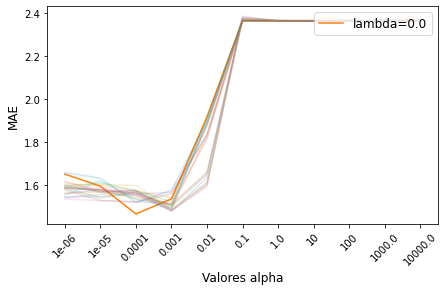

In [28]:
l_alpha = [1e-6, 1e-5, 1e-4, 0.001, 0.01, 0.1, 1.0, 10, 100, 1e+3, 1e+4, 1e+5]
res0 = comp1_K5.cv_results_['mean_test_score'][lw0]
plt.figure( figsize=(7,4))
print('best_alpha = %.4f' % comp1_K5.best_params_['regressor__mlp__l2'])
print('best_lw = %.4f' % comp1_K5.best_params_['regressor__mlp__lw'])
print('best_cv_mae = %.3f' % (comp1_K5.best_score_))
plt.xticks(range(len(l_alpha)), l_alpha, rotation=45)
plt.xlabel('Valores alpha', fontsize=12)
plt.ylabel("MAE", fontsize=12)
plt.plot(-res0, label = "lambda=0.0", color='C1')
plt.plot(-res1, alpha=0.2)
plt.plot(-res2, alpha=0.2)
plt.plot(-res3, alpha=0.2)
plt.plot(-res4, alpha=0.2)
plt.plot(-res5, alpha=0.2)
plt.plot(-res6, alpha=0.2)
plt.plot(-res7, alpha=0.2)
plt.plot(-res8, alpha=0.2)
plt.plot(-res9, alpha=0.2)
plt.plot(-res10, alpha=0.2)
plt.plot(-res11, alpha=0.2)
plt.plot(-res12, alpha=0.2)
plt.plot(-res13, alpha=0.2)
plt.plot(-res14, alpha=0.2)
plt.plot(-res15, alpha=0.2)
plt.plot(-res16, alpha=0.2)
plt.plot(-res17, alpha=0.2)
plt.plot(-res18, alpha=0.2)
plt.plot(-res19, alpha=0.2)
plt.legend(loc=1, prop={'size': 12})
plt.savefig('comp1_wrap_K28_param.png', bbox_inches = 'tight')
plt.show()


## Evaluación del modelo

In [9]:
set_seed(1)
kf = KFold(5, shuffle=True, random_state=1)
y_clas = y.copy()
y_clas[y_clas==29]=28
y_clas = y_clas - 1
target = np.concatenate([y.reshape(-1,1),y_clas.reshape(-1,1)], axis = 1)
res = cross_val_score(comp1_K5.best_estimator_, x, target, cv=kf, scoring=mi_scoring)
for i in range(2,4):
    kf = KFold(5, shuffle=True, random_state=i)
    set_seed(1)
    pred = cross_val_predict(comp1_K5.best_estimator_, x, target, cv=kf)
    res = np.dstack((res,pred))
    
result = np.mean(res[:,0,:], axis=1)
print(mean_absolute_error(result, y))

1.462093931937406


# Modelo mse + Fisher

## Escenario K=2

In [30]:
def network(l2, lw):
    """
    Builds functional MLP Keras model for companion categorical_crossentropy and mse losses,
    softmax and linear outputs respectively, relu activations, adam solver.
    
    ### Arguments:
        input_shape: feature dimension
        output_shape: target dimension
        hidden_layer_sizes: list with number of units on hidden layers
        regr_loss: regression loss; mse or mean_absolute_error
        alpha: parameter for l2 kernel regularizers for all layers
        
    ### Returns:
        model: Model
    """
    set_seed(123)
    input_layer = Input(shape=(8,),name = "input_layer")
    layer_1 = Dense(50, activation="relu", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'layer_1')(input_layer)
    layer_2 = Dense(50, activation="relu", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'layer_2')(layer_1)
    regr_layer = Dense(1, activation="linear", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'regr_layer')(layer_2)
    clas_layer = Dense(2, activation="softmax", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'clas_layer')(layer_2)
    ##Defining the model by specifying the input and output layers
    network_ = Model(inputs=[input_layer], outputs=[regr_layer, clas_layer])
    ## defining the optimiser and loss function
    network_.compile(optimizer='adam',
                   loss={'regr_layer':'mse','clas_layer': 'mse'},
                   loss_weights= {"regr_layer":1.0, "clas_layer": lw},
                   metrics = {'regr_layer':'mae', "clas_layer": 'accuracy'})
    return(network_)

def set_seed(seed):

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

    os.environ['PYTHONHASHSEED'] = str(seed)
    python_random.seed(seed)
    tensorflow.random.set_seed(seed)
    np.random.seed(seed)

class PartialMinMaxScaler(MinMaxScaler):
    """Applies the scaler in super() to the first column of the 
    numpy array to be scaled,
    """
    def fit(self, x):
        super().fit(x[ : , 0].reshape(-1, 1))
        
    def transform(self, x):
        xx = x.copy()
        xx_0 = super().transform(x[ : , 0].reshape(-1, 1))
        xx = np.concatenate([xx_0.reshape(-1,1),xx[:,1].reshape(-1,1)], axis = 1)
        return xx
        
    def fit_transform(self, x):
        self.fit(x)
        return self.transform(x)

    def inverse_transform(self, x):
        xx = x.copy()
        x_0 = super().inverse_transform(x[ : , 0].reshape(-1, 1))
        xx[ : , 0] = x_0.reshape(-1, )
        return xx


def fc_mae(y, y_pred, **kwargs):
    return -mean_absolute_error(y[ : , 0], y_pred) 

def abalone_data():
    data = pd.read_csv("datos.csv", sep = ' ',  header=None, encoding = "ISO-8859-1").dropna()
    data[1] = data[1].replace({'1:':''}, regex=True).astype(int)
    data[2] = data[2].replace({'2:':''}, regex=True).astype(float)
    data[3] = data[3].replace({'3:':''}, regex=True).astype(float)
    data[4] = data[4].replace({'4:':''}, regex=True).astype(float)
    data[5] = data[5].replace({'5:':''}, regex=True).astype(float)
    data[6] = data[6].replace({'6:':''}, regex=True).astype(float)
    data[7] = data[7].replace({'7:':''}, regex=True).astype(float)
    data[8] = data[8].replace({'8:':''}, regex=True).astype(float)
    x = data[[1,2,3,4,5,6,7,8]].values
    y = data[0].values
    return x,y

def fisher_y(y):
    """ y_ij = (n-n_j)/(n*sqrt(n_j)) if class(y_i)==j else -sqrt(n_j)/n """
    n = len(y)
    targets, counts = np.unique(y, return_counts=True)
    c = len(targets)
    lsrlda_y = np.zeros((n, c))
    for i, target in enumerate(y):
        t = targets.tolist().index(target)
        for j in range(c):
            if j==t:
                lsrlda_y[i, j] = (n - counts[t]) / (n * np.sqrt(counts[t]))
            else:
                lsrlda_y[i, j] = -np.sqrt(counts[t]/n)
    return lsrlda_y

class CompanionWrapper(BaseWrapper):
    """
    Predictions made on the RR outputs.
    """
    def __init__(self, model = network, **sk_params):
        BaseWrapper.__init__(self, model=model, **sk_params)
    def fit(self, x, y, **kwargs):
        """
        Assumes class codings as consecutive labels 0, 1, ...
        """        
        es = keras.callbacks.EarlyStopping(monitor="loss",
                                            min_delta=1.e-8,
                                            patience=50,
                                            verbose=0,
                                            mode="auto",
                                            baseline=None,
                                            restore_best_weights=True,
                                            )
        
        y_regr = y[:,0]
        y_clas = y[:,1]
        fishery = fisher_y(y_clas)
        
        self.X_dtype_ = type(x)
        self.X_shape_ = x.shape
        
        self.history_ = BaseWrapper.fit(self, x,
                                        {'regr_layer':y_regr,'clas_layer':fishery},
                                        epochs = self.epochs, initial_epoch = 0,
                                       callbacks = [es])

        return self.history_

    # Convertir la salida a rango [5,50.000] respetando el contexto.
    def predict(self, x, **kwargs):
        """
        We just drop the mse predictions of the model and keep the CE ones
        in the first returned list.
        """
        pred = BaseWrapper.predict(self, x)[0]
        return np.clip(pred, a_min = 0, a_max = 1)
    
    def score(self, x, y):
        y_pred = BaseWrapper.predict(self, x)[0]
        y_pred = np.clip(y_pred, a_min = 0, a_max = 1)
        return mean_absolute_error(y[:,0], y_pred)



## Ajuste de hiperparámetros

In [31]:
comp2_K2 = load('comp_wrap2_K2.joblib')

In [32]:
lw0 = []
lw1 = []
lw2 = []
lw3 = []
lw4 = []
lw5 = []
lw6 = []
lw7 = []
lw8 = []
lw9 = []
lw10 = []
lw11 = []
lw12 = []
lw13 = []
lw14 = []
lw15 = []
lw16 = []
lw17 = []
lw18 = []
lw19 = []
for i in range(0,220):
    if i % 20==0:
        lw0.append(i)
    elif i % 20==1:
        lw1.append(i)
    elif i % 20==2:
        lw2.append(i)
    elif i % 20==3:
        lw3.append(i)
    elif i % 20==4:
        lw4.append(i)
    elif i % 20==5:
        lw5.append(i)
    elif i % 20==6:
        lw6.append(i)
    elif i % 20==7:
        lw7.append(i)
    elif i % 20==8:
        lw8.append(i)
    elif i % 20==9:
        lw9.append(i)
    if i % 20==10:
        lw10.append(i)
    elif i % 20==11:
        lw11.append(i)
    elif i % 20==12:
        lw12.append(i)
    elif i % 20==13:
        lw13.append(i)
    elif i % 20==14:
        lw14.append(i)
    elif i % 20==15:
        lw15.append(i)
    elif i % 20==16:
        lw16.append(i)
    elif i % 20==17:
        lw17.append(i)
    elif i % 20==18:
        lw18.append(i)
    elif i % 20==19:
        lw19.append(i)
        
res0 = comp2_K2.cv_results_['mean_test_score'][lw0]
res1 = comp2_K2.cv_results_['mean_test_score'][lw1]
res2 = comp2_K2.cv_results_['mean_test_score'][lw2]
res3 = comp2_K2.cv_results_['mean_test_score'][lw3]
res4 = comp2_K2.cv_results_['mean_test_score'][lw4]
res5 = comp2_K2.cv_results_['mean_test_score'][lw5]
res6 = comp2_K2.cv_results_['mean_test_score'][lw6]
res7 = comp2_K2.cv_results_['mean_test_score'][lw7]
res8 = comp2_K2.cv_results_['mean_test_score'][lw8]
res9 = comp2_K2.cv_results_['mean_test_score'][lw9]
res10 = comp2_K2.cv_results_['mean_test_score'][lw10]
res11 = comp2_K2.cv_results_['mean_test_score'][lw11]
res12 = comp2_K2.cv_results_['mean_test_score'][lw12]
res13 = comp2_K2.cv_results_['mean_test_score'][lw13]
res14 = comp2_K2.cv_results_['mean_test_score'][lw14]
res15 = comp2_K2.cv_results_['mean_test_score'][lw15]
res16 = comp2_K2.cv_results_['mean_test_score'][lw16]
res17 = comp2_K2.cv_results_['mean_test_score'][lw17]
res18 = comp2_K2.cv_results_['mean_test_score'][lw18]
res19 = comp2_K2.cv_results_['mean_test_score'][lw19]


best_alpha = 0.00010
best_lw = 0.00000
best_cv_mae = -1.468


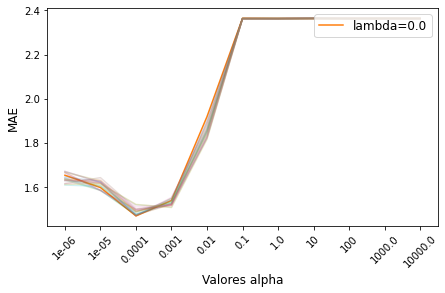

In [33]:
l_alpha = [1e-6, 1e-5, 1e-4, 0.001, 0.01, 0.1, 1.0, 10, 100, 1e+3, 1e+4, 1e+5]
res0 = comp2_K2.cv_results_['mean_test_score'][lw0]
plt.figure( figsize=(7,4))
print('best_alpha = %.5f' % comp2_K2.best_params_['regressor__mlp__l2'])
print('best_lw = %.5f' % comp2_K2.best_params_['regressor__mlp__lw'])
print('best_cv_mae = %.3f' % (comp2_K2.best_score_))
plt.xticks(range(len(l_alpha)), l_alpha, rotation=45)
plt.xlabel('Valores alpha', fontsize=12)
plt.ylabel("MAE", fontsize=12)
plt.plot(-res0, label = "lambda=0.0", color='C1')
plt.plot(-res1, alpha=0.2)
plt.plot(-res2, alpha=0.2)
plt.plot(-res3, alpha=0.2)
plt.plot(-res4, alpha=0.2)
plt.plot(-res5, alpha=0.2)
plt.plot(-res6, alpha=0.2)
plt.plot(-res7, alpha=0.2)
plt.plot(-res8, alpha=0.2)
plt.plot(-res9, alpha=0.2)
plt.plot(-res10, alpha=0.2)
plt.plot(-res11, alpha=0.2)
plt.plot(-res12, alpha=0.2)
plt.plot(-res13, alpha=0.2)
plt.plot(-res14, alpha=0.2)
plt.plot(-res15, alpha=0.2)
plt.plot(-res16, alpha=0.2)
plt.plot(-res17, alpha=0.2)
plt.plot(-res18, alpha=0.2)
plt.plot(-res19, alpha=0.2)
plt.legend(loc=1, prop={'size': 12})
plt.savefig('comp2_wrap_K2_param.png', bbox_inches = 'tight')
plt.show()


## Evaluación del modelo

In [9]:
set_seed(1)
kf = KFold(5, shuffle=True, random_state=1)
q = np.quantile(y, [0,.5,1])
y_clas = np.array(pd.cut(x=y.reshape(-1,), bins=q, labels=[0, 1], include_lowest=True, right=True))
target = np.concatenate([y.reshape(-1,1),y_clas.reshape(-1,1)], axis = 1)
res = cross_val_score(comp2_K2.best_estimator_, x, target, cv=kf, scoring=mi_scoring)
for i in range(2,4):
    kf = KFold(5, shuffle=True, random_state=i)
    set_seed(1)
    pred = cross_val_predict(comp2_K2.best_estimator_, x, target, cv=kf)
    res = np.dstack((res,pred))
    
result = np.mean(res[:,0,:], axis=1)
print(mean_absolute_error(result, y))

1.462093931937406


## Escenario K=5

In [10]:

def network(l2, lw):
    """
    Builds functional MLP Keras model for companion categorical_crossentropy and mse losses,
    softmax and linear outputs respectively, relu activations, adam solver.
    
    ### Arguments:
        input_shape: feature dimension
        output_shape: target dimension
        hidden_layer_sizes: list with number of units on hidden layers
        regr_loss: regression loss; mse or mean_absolute_error
        alpha: parameter for l2 kernel regularizers for all layers
        
    ### Returns:
        model: Model
    """
    set_seed(123)
    input_layer = Input(shape=(8,),name = "input_layer")
    layer_1 = Dense(50, activation="relu", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'layer_1')(input_layer)
    layer_2 = Dense(50, activation="relu", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'layer_2')(layer_1)
    regr_layer = Dense(1, activation="linear", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'regr_layer')(layer_2)
    clas_layer = Dense(5, activation="softmax", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'clas_layer')(layer_2)
    ##Defining the model by specifying the input and output layers
    network_ = Model(inputs=[input_layer], outputs=[regr_layer, clas_layer])
    ## defining the optimiser and loss function
    network_.compile(optimizer='adam',
                   loss={'regr_layer':'mse','clas_layer': 'mse'},
                   loss_weights= {"regr_layer":1.0, "clas_layer": lw},
                   metrics = {'regr_layer':'mae', "clas_layer": 'accuracy'})
    return(network_)

def set_seed(seed):

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

    os.environ['PYTHONHASHSEED'] = str(seed)
    python_random.seed(seed)
    tensorflow.random.set_seed(seed)
    np.random.seed(seed)

class PartialMinMaxScaler(MinMaxScaler):
    """Applies the scaler in super() to the first column of the 
    numpy array to be scaled,
    """
    def fit(self, x):
        super().fit(x[ : , 0].reshape(-1, 1))
        
    def transform(self, x):
        xx = x.copy()
        xx_0 = super().transform(x[ : , 0].reshape(-1, 1))
        xx = np.concatenate([xx_0.reshape(-1,1),xx[:,1].reshape(-1,1)], axis = 1)
        return xx
        
    def fit_transform(self, x):
        self.fit(x)
        return self.transform(x)

    def inverse_transform(self, x):
        xx = x.copy()
        x_0 = super().inverse_transform(x[ : , 0].reshape(-1, 1))
        xx[ : , 0] = x_0.reshape(-1, )
        return xx


def fc_mae(y, y_pred, **kwargs):
    return -mean_absolute_error(y[ : , 0], y_pred) 

def abalone_data():
    data = pd.read_csv("datos.csv", sep = ' ',  header=None, encoding = "ISO-8859-1").dropna()
    data[1] = data[1].replace({'1:':''}, regex=True).astype(int)
    data[2] = data[2].replace({'2:':''}, regex=True).astype(float)
    data[3] = data[3].replace({'3:':''}, regex=True).astype(float)
    data[4] = data[4].replace({'4:':''}, regex=True).astype(float)
    data[5] = data[5].replace({'5:':''}, regex=True).astype(float)
    data[6] = data[6].replace({'6:':''}, regex=True).astype(float)
    data[7] = data[7].replace({'7:':''}, regex=True).astype(float)
    data[8] = data[8].replace({'8:':''}, regex=True).astype(float)
    x = data[[1,2,3,4,5,6,7,8]].values
    y = data[0].values
    return x,y

def fisher_y(y):
    """ y_ij = (n-n_j)/(n*sqrt(n_j)) if class(y_i)==j else -sqrt(n_j)/n """
    n = len(y)
    targets, counts = np.unique(y, return_counts=True)
    c = len(targets)
    lsrlda_y = np.zeros((n, c))
    for i, target in enumerate(y):
        t = targets.tolist().index(target)
        for j in range(c):
            if j==t:
                lsrlda_y[i, j] = (n - counts[t]) / (n * np.sqrt(counts[t]))
            else:
                lsrlda_y[i, j] = -np.sqrt(counts[t]/n)
    return lsrlda_y

class CompanionWrapper(BaseWrapper):
    """
    Predictions made on the RR outputs.
    """
    def __init__(self, model = network, **sk_params):
        BaseWrapper.__init__(self, model=model, **sk_params)
    def fit(self, x, y, **kwargs):
        """
        Assumes class codings as consecutive labels 0, 1, ...
        """        
        es = keras.callbacks.EarlyStopping(monitor="loss",
                                            min_delta=1.e-8,
                                            patience=50,
                                            verbose=0,
                                            mode="auto",
                                            baseline=None,
                                            restore_best_weights=True,
                                            )
        
        y_regr = y[:,0]
        y_clas = y[:,1]
        fishery = fisher_y(y_clas)
        
        self.X_dtype_ = type(x)
        self.X_shape_ = x.shape
        
        self.history_ = BaseWrapper.fit(self, x,
                                        {'regr_layer':y_regr,'clas_layer':fishery},
                                        epochs = self.epochs, initial_epoch = 0,
                                       callbacks = [es])

        return self.history_

    # Convertir la salida a rango [5,50.000] respetando el contexto.
    def predict(self, x, **kwargs):
        """
        We just drop the mse predictions of the model and keep the CE ones
        in the first returned list.
        """
        pred = BaseWrapper.predict(self, x)[0]
        return np.clip(pred, a_min = 0, a_max = 1)
    
    def score(self, x, y):
        y_pred = BaseWrapper.predict(self, x)[0]
        y_pred = np.clip(y_pred, a_min = 0, a_max = 1)
        return mean_absolute_error(y[:,0], y_pred)



## Ajuste de hiperparámetros

In [11]:
comp2_K3 = load('comp_wrap2_K5.joblib')

In [12]:
lw0 = []
lw1 = []
lw2 = []
lw3 = []
lw4 = []
lw5 = []
lw6 = []
lw7 = []
lw8 = []
lw9 = []
lw10 = []
lw11 = []
lw12 = []
lw13 = []
lw14 = []
lw15 = []
lw16 = []
lw17 = []
lw18 = []
lw19 = []
for i in range(0,220):
    if i % 20==0:
        lw0.append(i)
    elif i % 20==1:
        lw1.append(i)
    elif i % 20==2:
        lw2.append(i)
    elif i % 20==3:
        lw3.append(i)
    elif i % 20==4:
        lw4.append(i)
    elif i % 20==5:
        lw5.append(i)
    elif i % 20==6:
        lw6.append(i)
    elif i % 20==7:
        lw7.append(i)
    elif i % 20==8:
        lw8.append(i)
    elif i % 20==9:
        lw9.append(i)
    if i % 20==10:
        lw10.append(i)
    elif i % 20==11:
        lw11.append(i)
    elif i % 20==12:
        lw12.append(i)
    elif i % 20==13:
        lw13.append(i)
    elif i % 20==14:
        lw14.append(i)
    elif i % 20==15:
        lw15.append(i)
    elif i % 20==16:
        lw16.append(i)
    elif i % 20==17:
        lw17.append(i)
    elif i % 20==18:
        lw18.append(i)
    elif i % 20==19:
        lw19.append(i)
        
res0 = comp2_K3.cv_results_['mean_test_score'][lw0]
res1 = comp2_K3.cv_results_['mean_test_score'][lw1]
res2 = comp2_K3.cv_results_['mean_test_score'][lw2]
res3 = comp2_K3.cv_results_['mean_test_score'][lw3]
res4 = comp2_K3.cv_results_['mean_test_score'][lw4]
res5 = comp2_K3.cv_results_['mean_test_score'][lw5]
res6 = comp2_K3.cv_results_['mean_test_score'][lw6]
res7 = comp2_K3.cv_results_['mean_test_score'][lw7]
res8 = comp2_K3.cv_results_['mean_test_score'][lw8]
res9 = comp2_K3.cv_results_['mean_test_score'][lw9]
res10 = comp2_K3.cv_results_['mean_test_score'][lw10]
res11 = comp2_K3.cv_results_['mean_test_score'][lw11]
res12 = comp2_K3.cv_results_['mean_test_score'][lw12]
res13 = comp2_K3.cv_results_['mean_test_score'][lw13]
res14 = comp2_K3.cv_results_['mean_test_score'][lw14]
res15 = comp2_K3.cv_results_['mean_test_score'][lw15]
res16 = comp2_K3.cv_results_['mean_test_score'][lw16]
res17 = comp2_K3.cv_results_['mean_test_score'][lw17]
res18 = comp2_K3.cv_results_['mean_test_score'][lw18]
res19 = comp2_K3.cv_results_['mean_test_score'][lw19]


best_alpha = 0.000100
best_lw = 0.750000
best_cv_mae = -1.465158


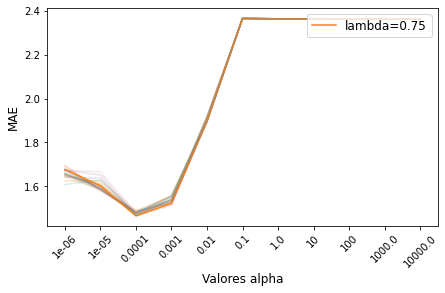

In [13]:
l_alpha = [1e-6, 1e-5, 1e-4, 0.001, 0.01, 0.1, 1.0, 10, 100, 1e+3, 1e+4, 1e+5]
res0 = comp2_K3.cv_results_['mean_test_score'][lw0]
plt.figure( figsize=(7,4))
print('best_alpha = %.6f' % comp2_K3.best_params_['regressor__mlp__l2'])
print('best_lw = %.6f' % comp2_K3.best_params_['regressor__mlp__lw'])
print('best_cv_mae = %.6f' % (comp2_K3.best_score_))
plt.xticks(range(len(l_alpha)), l_alpha, rotation=45)
plt.xlabel('Valores alpha', fontsize=12)
plt.ylabel("MAE", fontsize=12)
plt.plot(-res0, alpha=0.2)
plt.plot(-res1, alpha=0.2)
plt.plot(-res2, alpha=0.2)
plt.plot(-res3, alpha=0.2)
plt.plot(-res4, alpha=0.2)
plt.plot(-res5, alpha=0.2)
plt.plot(-res6, alpha=0.2)
plt.plot(-res7, alpha=0.2)
plt.plot(-res8, alpha=0.2)
plt.plot(-res9, alpha=0.2)
plt.plot(-res10, alpha=0.2)
plt.plot(-res11, alpha=0.2)
plt.plot(-res12, alpha=0.2)
plt.plot(-res13, alpha=0.2)
plt.plot(-res14, alpha=0.2)
plt.plot(-res15, label = "lambda=0.75", color='C1')
plt.plot(-res16, alpha=0.2)
plt.plot(-res17, alpha=0.2)
plt.plot(-res18, alpha=0.2)
plt.plot(-res19, alpha=0.2)
plt.legend(loc=1, prop={'size': 12})
plt.savefig('comp2_wrap_K5_param.png', bbox_inches = 'tight')
plt.show()


## Evaluación del modelo

In [14]:
set_seed(1)
kf = KFold(5, shuffle=True, random_state=1)
q = np.quantile(y, [0,.2,.4,.6,.8,1])
y_clas = np.array(pd.cut(x=y.reshape(-1,), bins=q, labels=[0, 1,2,3,4], include_lowest=True, right=True))
target = np.concatenate([y.reshape(-1,1),y_clas.reshape(-1,1)], axis = 1)
kf = KFold(5, shuffle=True, random_state=1)
res = cross_val_predict(comp2_K3.best_estimator_, x, target, cv=kf)
for i in range(2,4):
    kf = KFold(5, shuffle=True, random_state=i)
    set_seed(1)
    pred = cross_val_predict(comp2_K3.best_estimator_, x, target, cv=kf)
    res = np.dstack((res,pred))
    
result = np.mean(res[:,0,:], axis=1)
print(mean_absolute_error(result, y))

1.4644298532347602


## Escenario K=4

In [15]:

def network(l2, lw):
    """
    Builds functional MLP Keras model for companion categorical_crossentropy and mse losses,
    softmax and linear outputs respectively, relu activations, adam solver.
    
    ### Arguments:
        input_shape: feature dimension
        output_shape: target dimension
        hidden_layer_sizes: list with number of units on hidden layers
        regr_loss: regression loss; mse or mean_absolute_error
        alpha: parameter for l2 kernel regularizers for all layers
        
    ### Returns:
        model: Model
    """
    set_seed(123)
    input_layer = Input(shape=(8,),name = "input_layer")
    layer_1 = Dense(50, activation="relu", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'layer_1')(input_layer)
    layer_2 = Dense(50, activation="relu", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'layer_2')(layer_1)
    regr_layer = Dense(1, activation="linear", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'regr_layer')(layer_2)
    clas_layer = Dense(4, activation="softmax", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'clas_layer')(layer_2)
    ##Defining the model by specifying the input and output layers
    network_ = Model(inputs=[input_layer], outputs=[regr_layer, clas_layer])
    ## defining the optimiser and loss function
    network_.compile(optimizer='adam',
                   loss={'regr_layer':'mse','clas_layer': 'mse'},
                   loss_weights= {"regr_layer":1.0, "clas_layer": lw},
                   metrics = {'regr_layer':'mae', "clas_layer": 'accuracy'})
    return(network_)

def set_seed(seed):

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

    os.environ['PYTHONHASHSEED'] = str(seed)
    python_random.seed(seed)
    tensorflow.random.set_seed(seed)
    np.random.seed(seed)

def fisher_y(y):
    """ y_ij = (n-n_j)/(n*sqrt(n_j)) if class(y_i)==j else -sqrt(n_j)/n """
    n = len(y)
    targets, counts = np.unique(y, return_counts=True)
    c = len(targets)
    lsrlda_y = np.zeros((n, c))
    for i, target in enumerate(y):
        t = targets.tolist().index(target)
        for j in range(c):
            if j==t:
                lsrlda_y[i, j] = (n - counts[t]) / (n * np.sqrt(counts[t]))
            else:
                lsrlda_y[i, j] = -np.sqrt(counts[t]/n)
    return lsrlda_y

class PartialMinMaxScaler(MinMaxScaler):
    """Applies the scaler in super() to the first column of the 
    numpy array to be scaled,
    """
    def fit(self, x):
        super().fit(x[ : , 0].reshape(-1, 1))
        
    def transform(self, x):
        xx = x.copy()
        xx_0 = super().transform(x[ : , 0].reshape(-1, 1))
        xx = np.concatenate([xx_0.reshape(-1,1),xx[:,1].reshape(-1,1)], axis = 1)
        return xx
        
    def fit_transform(self, x):
        self.fit(x)
        return self.transform(x)

    def inverse_transform(self, x):
        xx = x.copy()
        x_0 = super().inverse_transform(x[ : , 0].reshape(-1, 1))
        xx[ : , 0] = x_0.reshape(-1, )
        return xx


def fc_mae(y, y_pred, **kwargs):
    return -mean_absolute_error(y[ : , 0], y_pred) 

def abalone_data():
    data = pd.read_csv("datos.csv", sep = ' ',  header=None, encoding = "ISO-8859-1").dropna()
    data[1] = data[1].replace({'1:':''}, regex=True).astype(int)
    data[2] = data[2].replace({'2:':''}, regex=True).astype(float)
    data[3] = data[3].replace({'3:':''}, regex=True).astype(float)
    data[4] = data[4].replace({'4:':''}, regex=True).astype(float)
    data[5] = data[5].replace({'5:':''}, regex=True).astype(float)
    data[6] = data[6].replace({'6:':''}, regex=True).astype(float)
    data[7] = data[7].replace({'7:':''}, regex=True).astype(float)
    data[8] = data[8].replace({'8:':''}, regex=True).astype(float)
    x = data[[1,2,3,4,5,6,7,8]].values
    y = data[0].values
    return x,y


class CompanionWrapper(BaseWrapper):
    """
    Predictions made on the RR outputs.
    """
    def __init__(self, model = network, **sk_params):
        BaseWrapper.__init__(self, model=model, **sk_params)
    def fit(self, x, y, **kwargs):
        """
        Assumes class codings as consecutive labels 0, 1, ...
        """        
        es = keras.callbacks.EarlyStopping(monitor="loss",
                                            min_delta=1.e-8,
                                            patience=50,
                                            verbose=0,
                                            mode="auto",
                                            baseline=None,
                                            restore_best_weights=True,
                                            )
        
        y_regr = y[:,0]
        y_clas = y[:,1]
        fishery = fisher_y(y_clas)
        
        self.X_dtype_ = type(x)
        self.X_shape_ = x.shape
        
        self.history_ = BaseWrapper.fit(self, x,
                                        {'regr_layer':y_regr,'clas_layer':fishery},
                                        epochs = self.epochs, initial_epoch = 0,
                                       callbacks = [es])

        return self.history_

    # Convertir la salida a rango [5,50.000] respetando el contexto.
    def predict(self, x, **kwargs):
        """
        We just drop the mse predictions of the model and keep the CE ones
        in the first returned list.
        """
        pred = BaseWrapper.predict(self, x)[0]
        return np.clip(pred, a_min = 0, a_max = 1)
    
    def score(self, x, y):
        y_pred = BaseWrapper.predict(self, x)[0]
        y_pred = np.clip(y_pred, a_min = 0, a_max = 1)
        return mean_absolute_error(y[:,0], y_pred)


## Ajuste de hiperparámetros

In [16]:
comp2_K4 = load('comp_wrap2_K4.joblib')

In [17]:
lw0 = []
lw1 = []
lw2 = []
lw3 = []
lw4 = []
lw5 = []
lw6 = []
lw7 = []
lw8 = []
lw9 = []
lw10 = []
lw11 = []
lw12 = []
lw13 = []
lw14 = []
lw15 = []
lw16 = []
lw17 = []
lw18 = []
lw19 = []
for i in range(0,220):
    if i % 20==0:
        lw0.append(i)
    elif i % 20==1:
        lw1.append(i)
    elif i % 20==2:
        lw2.append(i)
    elif i % 20==3:
        lw3.append(i)
    elif i % 20==4:
        lw4.append(i)
    elif i % 20==5:
        lw5.append(i)
    elif i % 20==6:
        lw6.append(i)
    elif i % 20==7:
        lw7.append(i)
    elif i % 20==8:
        lw8.append(i)
    elif i % 20==9:
        lw9.append(i)
    if i % 20==10:
        lw10.append(i)
    elif i % 20==11:
        lw11.append(i)
    elif i % 20==12:
        lw12.append(i)
    elif i % 20==13:
        lw13.append(i)
    elif i % 20==14:
        lw14.append(i)
    elif i % 20==15:
        lw15.append(i)
    elif i % 20==16:
        lw16.append(i)
    elif i % 20==17:
        lw17.append(i)
    elif i % 20==18:
        lw18.append(i)
    elif i % 20==19:
        lw19.append(i)
        
res0 = comp2_K4.cv_results_['mean_test_score'][lw0]
res1 = comp2_K4.cv_results_['mean_test_score'][lw1]
res2 = comp2_K4.cv_results_['mean_test_score'][lw2]
res3 = comp2_K4.cv_results_['mean_test_score'][lw3]
res4 = comp2_K4.cv_results_['mean_test_score'][lw4]
res5 = comp2_K4.cv_results_['mean_test_score'][lw5]
res6 = comp2_K4.cv_results_['mean_test_score'][lw6]
res7 = comp2_K4.cv_results_['mean_test_score'][lw7]
res8 = comp2_K4.cv_results_['mean_test_score'][lw8]
res9 = comp2_K4.cv_results_['mean_test_score'][lw9]
res10 = comp2_K4.cv_results_['mean_test_score'][lw10]
res11 = comp2_K4.cv_results_['mean_test_score'][lw11]
res12 = comp2_K4.cv_results_['mean_test_score'][lw12]
res13 = comp2_K4.cv_results_['mean_test_score'][lw13]
res14 = comp2_K4.cv_results_['mean_test_score'][lw14]
res15 = comp2_K4.cv_results_['mean_test_score'][lw15]
res16 = comp2_K4.cv_results_['mean_test_score'][lw16]
res17 = comp2_K4.cv_results_['mean_test_score'][lw17]
res18 = comp2_K4.cv_results_['mean_test_score'][lw18]
res19 = comp2_K4.cv_results_['mean_test_score'][lw19]

best_alpha = 0.000100
best_lw = 0.6000
best_cv_mae = -1.465


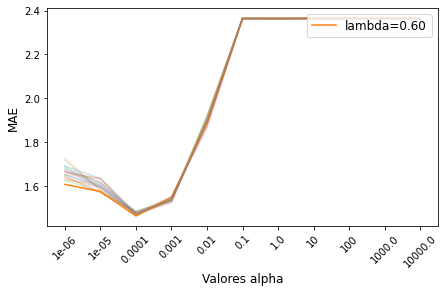

In [18]:
l_alpha = [1e-6, 1e-5, 1e-4, 0.001, 0.01, 0.1, 1.0, 10, 100, 1e+3, 1e+4, 1e+5]
res0 = comp2_K4.cv_results_['mean_test_score'][lw0]
plt.figure( figsize=(7,4))
print('best_alpha = %.6f' % comp2_K4.best_params_['regressor__mlp__l2'])
print('best_lw = %.4f' % comp2_K4.best_params_['regressor__mlp__lw'])
print('best_cv_mae = %.3f' % (comp2_K4.best_score_))
plt.xticks(range(len(l_alpha)), l_alpha, rotation=45)
plt.xlabel('Valores alpha', fontsize=12)
plt.ylabel("MAE", fontsize=12)
plt.plot(-res0, alpha=0.2)
plt.plot(-res1, alpha=0.2)
plt.plot(-res2, alpha=0.2)
plt.plot(-res3, alpha=0.2)
plt.plot(-res4, alpha=0.2)
plt.plot(-res5, alpha=0.2)
plt.plot(-res6, alpha=0.2)
plt.plot(-res7, alpha=0.2)
plt.plot(-res8, alpha=0.2)
plt.plot(-res9, alpha=0.2)
plt.plot(-res10, alpha=0.2)
plt.plot(-res11, alpha=0.2)
plt.plot(-res12, label = "lambda=0.60", color='C1')
plt.plot(-res13, alpha=0.2)
plt.plot(-res14, alpha=0.2)
plt.plot(-res15, alpha=0.2)
plt.plot(-res16, alpha=0.2)
plt.plot(-res17, alpha=0.2)
plt.plot(-res18, alpha=0.2)
plt.plot(-res19, alpha=0.2)
plt.legend(loc=1, prop={'size': 12})
plt.savefig('comp2_wrap_K4_param.png', bbox_inches = 'tight')
plt.show()


## Evaluación del modelo

In [19]:
set_seed(1)
kf = KFold(5, shuffle=True, random_state=1)
q = np.quantile(y, [0,.25,.5,.75,1])
y_clas = np.array(pd.cut(x=y.reshape(-1,), bins=q, labels=[0, 1,2,3], include_lowest=True, right=True))
target = np.concatenate([y.reshape(-1,1),y_clas.reshape(-1,1)], axis = 1)
kf = KFold(5, shuffle=True, random_state=1)
res = cross_val_predict(comp2_K4.best_estimator_, x, target, cv=kf)
for i in range(2,4):
    kf = KFold(5, shuffle=True, random_state=i)
    set_seed(1)
    pred = cross_val_predict(comp2_K4.best_estimator_, x, target, cv=kf)
    res = np.dstack((res,pred))
    
result = np.mean(res[:,0,:], axis=1)
print(mean_absolute_error(result, y))

1.465123533917181


## Escenario K=28 (modelo óptimo)

In [3]:

def network(l2, lw):
    """
    Builds functional MLP Keras model for companion categorical_crossentropy and mse losses,
    softmax and linear outputs respectively, relu activations, adam solver.
    
    ### Arguments:
        input_shape: feature dimension
        output_shape: target dimension
        hidden_layer_sizes: list with number of units on hidden layers
        regr_loss: regression loss; mse or mean_absolute_error
        alpha: parameter for l2 kernel regularizers for all layers
        
    ### Returns:
        model: Model
    """
    set_seed(123)
    input_layer = Input(shape=(8,),name = "input_layer")
    layer_1 = Dense(50, activation="relu", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'layer_1')(input_layer)
    layer_2 = Dense(50, activation="relu", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'layer_2')(layer_1)
    regr_layer = Dense(1, activation="linear", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'regr_layer')(layer_2)
    clas_layer = Dense(28, activation="softmax", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'clas_layer')(layer_2)
    ##Defining the model by specifying the input and output layers
    network_ = Model(inputs=[input_layer], outputs=[regr_layer, clas_layer])
    ## defining the optimiser and loss function
    network_.compile(optimizer='adam',
                   loss={'regr_layer':'mse','clas_layer': 'mse'},
                   loss_weights= {"regr_layer":1.0, "clas_layer": lw},
                   metrics = {'regr_layer':'mae', "clas_layer": 'accuracy'})
    return(network_)

def set_seed(seed):

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

    os.environ['PYTHONHASHSEED'] = str(seed)
    python_random.seed(seed)
    tensorflow.random.set_seed(seed)
    np.random.seed(seed)

class PartialMinMaxScaler(MinMaxScaler):
    """Applies the scaler in super() to the first column of the 
    numpy array to be scaled,
    """
    def fit(self, x):
        super().fit(x[ : , 0].reshape(-1, 1))
        
    def transform(self, x):
        xx = x.copy()
        xx_0 = super().transform(x[ : , 0].reshape(-1, 1))
        xx = np.concatenate([xx_0.reshape(-1,1),xx[:,1].reshape(-1,1)], axis = 1)
        return xx
        
    def fit_transform(self, x):
        self.fit(x)
        return self.transform(x)

    def inverse_transform(self, x):
        xx = x.copy()
        x_0 = super().inverse_transform(x[ : , 0].reshape(-1, 1))
        xx[ : , 0] = x_0.reshape(-1, )
        return xx


def fc_mae(y, y_pred, **kwargs):
    return -mean_absolute_error(y[ : , 0], y_pred) 

def abalone_data():
    data = pd.read_csv("datos.csv", sep = ' ',  header=None, encoding = "ISO-8859-1").dropna()
    data[1] = data[1].replace({'1:':''}, regex=True).astype(int)
    data[2] = data[2].replace({'2:':''}, regex=True).astype(float)
    data[3] = data[3].replace({'3:':''}, regex=True).astype(float)
    data[4] = data[4].replace({'4:':''}, regex=True).astype(float)
    data[5] = data[5].replace({'5:':''}, regex=True).astype(float)
    data[6] = data[6].replace({'6:':''}, regex=True).astype(float)
    data[7] = data[7].replace({'7:':''}, regex=True).astype(float)
    data[8] = data[8].replace({'8:':''}, regex=True).astype(float)
    x = data[[1,2,3,4,5,6,7,8]].values
    y = data[0].values
    return x,y


def fisher_y(y, num_classes=None):
    """ y_ij = (n-n_j)/(n*sqrt(n_j)) if class(y_i)==j else -sqrt(n_j)/n """
    n = len(y)
    targets, counts = np.unique(y, return_counts=True)
    if num_classes==None:
        c = len(targets)
    else:
        c = num_classes
    lsrlda_y = np.zeros((n, c))
    for i, target in enumerate(y):
        t = targets.tolist().index(target)
        for j in range(c):
            if j==t:
                lsrlda_y[i, j] = (n - counts[t]) / (n * np.sqrt(counts[t]))
            else:
                lsrlda_y[i, j] = -np.sqrt(counts[t]/n)
    return lsrlda_y

class CompanionWrapper(BaseWrapper):
    """
    Predictions made on the RR outputs.
    """
    def __init__(self, model = network, **sk_params):
        BaseWrapper.__init__(self, model=model, **sk_params)
    def fit(self, x, y, **kwargs):
        """
        Assumes class codings as consecutive labels 0, 1, ...
        """        
        es = keras.callbacks.EarlyStopping(monitor="loss",
                                            min_delta=1.e-8,
                                            patience=50,
                                            verbose=0,
                                            mode="auto",
                                            baseline=None,
                                            restore_best_weights=True,
                                            )
        
        y_regr = y[:,0]
        y_clas = y[:,1]
        fishery = fisher_y(y_clas, num_classes=28)
        
        self.X_dtype_ = type(x)
        self.X_shape_ = x.shape
        
        self.history_ = BaseWrapper.fit(self, x,
                                        {'regr_layer':y_regr,'clas_layer':fishery},
                                        epochs = self.epochs, initial_epoch = 0,
                                       callbacks = [es])

        return self.history_

    # Convertir la salida a rango [5,50.000] respetando el contexto.
    def predict(self, x, **kwargs):
        """
        We just drop the mse predictions of the model and keep the CE ones
        in the first returned list.
        """
        pred = BaseWrapper.predict(self, x)[0]
        return np.clip(pred, a_min = 0, a_max = 1)
    
    def score(self, x, y):
        y_pred = BaseWrapper.predict(self, x)[0]
        y_pred = np.clip(y_pred, a_min = 0, a_max = 1)
        return mean_absolute_error(y[:,0], y_pred)



## Ajuste de hiperparámetros

In [4]:
comp2_K5 = load('comp_wrap2_K28.joblib')

In [5]:
lw0 = []
lw1 = []
lw2 = []
lw3 = []
lw4 = []
lw5 = []
lw6 = []
lw7 = []
lw8 = []
lw9 = []
lw10 = []
lw11 = []
lw12 = []
lw13 = []
lw14 = []
lw15 = []
lw16 = []
lw17 = []
lw18 = []
lw19 = []
for i in range(0,220):
    if i % 20==0:
        lw0.append(i)
    elif i % 20==1:
        lw1.append(i)
    elif i % 20==2:
        lw2.append(i)
    elif i % 20==3:
        lw3.append(i)
    elif i % 20==4:
        lw4.append(i)
    elif i % 20==5:
        lw5.append(i)
    elif i % 20==6:
        lw6.append(i)
    elif i % 20==7:
        lw7.append(i)
    elif i % 20==8:
        lw8.append(i)
    elif i % 20==9:
        lw9.append(i)
    if i % 20==10:
        lw10.append(i)
    elif i % 20==11:
        lw11.append(i)
    elif i % 20==12:
        lw12.append(i)
    elif i % 20==13:
        lw13.append(i)
    elif i % 20==14:
        lw14.append(i)
    elif i % 20==15:
        lw15.append(i)
    elif i % 20==16:
        lw16.append(i)
    elif i % 20==17:
        lw17.append(i)
    elif i % 20==18:
        lw18.append(i)
    elif i % 20==19:
        lw19.append(i)
        
res0 = comp2_K5.cv_results_['mean_test_score'][lw0]
res1 = comp2_K5.cv_results_['mean_test_score'][lw1]
res2 = comp2_K5.cv_results_['mean_test_score'][lw2]
res3 = comp2_K5.cv_results_['mean_test_score'][lw3]
res4 = comp2_K5.cv_results_['mean_test_score'][lw4]
res5 = comp2_K5.cv_results_['mean_test_score'][lw5]
res6 = comp2_K5.cv_results_['mean_test_score'][lw6]
res7 = comp2_K5.cv_results_['mean_test_score'][lw7]
res8 = comp2_K5.cv_results_['mean_test_score'][lw8]
res9 = comp2_K5.cv_results_['mean_test_score'][lw9]
res10 = comp2_K5.cv_results_['mean_test_score'][lw10]
res11 = comp2_K5.cv_results_['mean_test_score'][lw11]
res12 = comp2_K5.cv_results_['mean_test_score'][lw12]
res13 = comp2_K5.cv_results_['mean_test_score'][lw13]
res14 = comp2_K5.cv_results_['mean_test_score'][lw14]
res15 = comp2_K5.cv_results_['mean_test_score'][lw15]
res16 = comp2_K5.cv_results_['mean_test_score'][lw16]
res17 = comp2_K5.cv_results_['mean_test_score'][lw17]
res18 = comp2_K5.cv_results_['mean_test_score'][lw18]
res19 = comp2_K5.cv_results_['mean_test_score'][lw19]


best_alpha = 0.0001
best_lw = 0.6000
best_cv_mae = -1.457


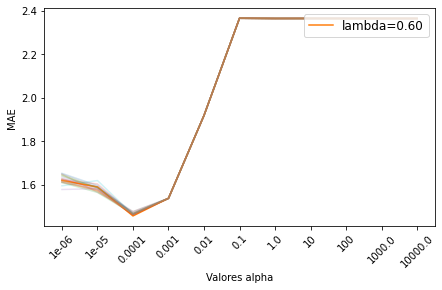

In [6]:
l_alpha = [1e-6, 1e-5, 1e-4, 0.001, 0.01, 0.1, 1.0, 10, 100, 1e+3, 1e+4, 1e+5]
res0 = comp2_K5.cv_results_['mean_test_score'][lw0]
plt.figure( figsize=(7,4))
print('best_alpha = %.4f' % comp2_K5.best_params_['regressor__mlp__l2'])
print('best_lw = %.4f' % comp2_K5.best_params_['regressor__mlp__lw'])
print('best_cv_mae = %.3f' % (comp2_K5.best_score_))
plt.xticks(range(len(l_alpha)), l_alpha, rotation=45)
plt.xlabel('Valores alpha')
plt.ylabel("MAE")
plt.plot(-res0, alpha=0.2)
plt.plot(-res1, alpha=0.2)
plt.plot(-res2, alpha=0.2)
plt.plot(-res3, alpha=0.2)
plt.plot(-res4, alpha=0.2)
plt.plot(-res5, alpha=0.2)
plt.plot(-res6, alpha=0.2)
plt.plot(-res7, alpha=0.2)
plt.plot(-res8, alpha=0.2)
plt.plot(-res9, alpha=0.2)
plt.plot(-res10, alpha=0.2)
plt.plot(-res11, alpha=0.2)
plt.plot(-res12, label="lambda=0.60", color='C1')
plt.plot(-res13, alpha=0.2)
plt.plot(-res14, alpha=0.2)
plt.plot(-res15, alpha=0.2)
plt.plot(-res16, alpha=0.2)
plt.plot(-res17, alpha=0.2)
plt.plot(-res18, alpha=0.2)
plt.plot(-res19, alpha=0.2)
plt.legend(loc=1, prop={'size': 12})
plt.savefig('comp2_wrap_K28_param.png', bbox_inches = 'tight')
plt.show()


## Evaluación del modelo

In [7]:
set_seed(1)
kf = KFold(5, shuffle=True, random_state=1)
y_clas = y.copy()
y_clas[y_clas==29]=28
y_clas = y_clas - 1
target = np.concatenate([y.reshape(-1,1),y_clas.reshape(-1,1)], axis = 1)
kf = KFold(5, shuffle=True, random_state=1)
res = cross_val_predict(comp2_K5.best_estimator_, x, target, cv=kf)
for i in range(2,4):
    kf = KFold(5, shuffle=True, random_state=i)
    set_seed(1)
    pred = cross_val_predict(comp2_K5.best_estimator_, x, target, cv=kf)
    res = np.dstack((res,pred))
    
result = np.mean(res[:,0,:], axis=1)
print(mean_absolute_error(result, y))

1.4605286631653804


## Evaluación de resultados del modelo

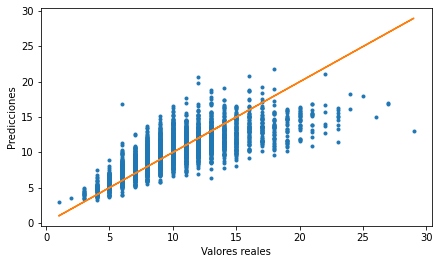

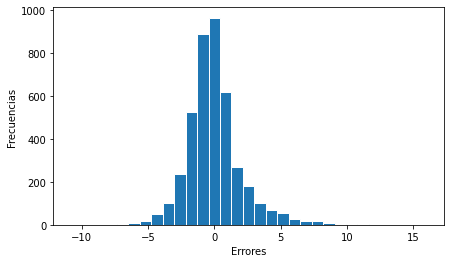

In [8]:
plt.figure( figsize=(7,4))
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
_ = plt.plot(y, result, '.', y, y, '-')
plt.savefig('predi.png', bbox_inches = 'tight')
plt.show()

err = y.reshape(-1,) - result.reshape(-1,)
plt.figure( figsize=(7,4))
plt.xlabel("Errores")
plt.ylabel("Frecuencias")
_ = plt.hist(err, bins=31, ec = 'white')
plt.savefig('hist.png', bbox_inches = 'tight')
plt.show()

